# Magic data analysis

### Description

The data are Monte Carlo generated to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background). 

Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions. 

The program was run with parameters allowing to observe events with energies down to below 50 GeV.

### Dataset

The dataset is available at this [link](https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data)

Attribute Information:

1. fLength: continuous # major axis of ellipse [mm] 
2. fWidth: continuous # minor axis of ellipse [mm] 
3. fSize: continuous # 10-log of sum of content of all pixels [in #phot] 
4. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio] 
5. fConc1: continuous # ratio of highest pixel over fSize [ratio] 
6. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm] 
7. fM3Long: continuous # 3rd root of third moment along major axis [mm] 
8. fM3Trans: continuous # 3rd root of third moment along minor axis [mm] 
9. fAlpha: continuous # angle of major axis with vector to origin [deg] 
10. fDist: continuous # distance from origin to center of ellipse [mm] 
11. class: g,h # gamma (signal), hadron (background) 

g = gamma (signal): 12332 
h = hadron (background): 6688 

For technical reasons, the number of h events is underestimated. In the real data, the h class represents the majority of the events. 

The simple classification accuracy is not meaningful for this data, since classifying a background event as signal is worse than classifying a signal event as background. For comparison of different classifiers an ROC curve has to be used. The relevant points on this curve are those, where the probability of accepting a background event as signal is below one of the following thresholds: 0.01, 0.02, 0.05, 0.1, 0.2 depending on the required quality of the sample of the accepted events for different experiments.


### References

Bock, R.K., Chilingarian, A., Gaug, M., Hakl, F., Hengstebeck, T., Jirina, M., Klaschka, J., Kotrc, E., Savicky, P., Towers, S., Vaicilius, A., Wittek W. (2004). 
Methods for multidimensional event classification: a case study using images from a Cherenkov gamma-ray telescope. 
Nucl.Instr.Meth. A, 516, pp. 511-528. 

P. Savicky, E. Kotrc. 
Experimental Study of Leaf Confidences for Random Forest. 
Proceedings of COMPSTAT 2004, In: Computational Statistics. (Ed.: Antoch J.) - Heidelberg, Physica Verlag 2004, pp. 1767-1774. 

J. Dvorak, P. Savicky. 
Softening Splits in Decision Trees Using Simulated Annealing. 
Proceedings of ICANNGA 2007, Warsaw, (Ed.: Beliczynski et. al), Part I, LNCS 4431, pp. 721-729.

Aharonian, F. et al.
The Energy Spectrum of TeV Gamma-Rays from the Crab Nebula as measured by the HEGRA system of imaging air Cherenkov telescopes
Astrophys. J. 539 (2000) 317-324

Aleksic, J. et al.
Measurement of the Crab Nebula spectrum over three decades in energy with the MAGIC telescopes
Journal of High Energy Astrophysics, 5–6 (2015) 30-38.

### Assignments

The main goal is to distinguish signal and background events. Two approaches can be followed: 1) exploiting the physics of the detection principle 2) use a physics-agnostic multivariate technique, e.g. a neural network.

* Study the features of the datasets and compare them for signal and background events
* Study the correlations among the features of the datasets for signal and background events
* Compute the "mean-scaled-width" and the "mean-scale-length", i.e. rescale by means of their mean and standard deviation the "Width" and "Length" distributions. Compare them for signal and background events in the cases of little or a lot of light ("fSize") 
* Perform a Principal Component Analysis on that dataset for the signal and the background events
* Perform a multivariate analysis, without using the parameter `fAlpha` for the classification, with the technique you prefer and evaluate its performance (e.g. in terms of Area Under the (ROC) Curve).
*  If we call "gammaness" the score that you give when you classify an event as gamma or hadron (that has been trained without using `fAlpha`), find the gammaness and alpha cuts that are giving the highest quality factor. 

Since you have a dataset that does not correspond to reality (in which hadrons are much more numerous than gammas), we define the quality factor **Q** as:
    
   **Q** = epsilon_gamma / sqrt(epsilon_hadron); where
   
   epsilon_gamma = selected_gammas / total_number_of_gammas
   
   epsilon_hadron = selected_hadrons / total_number_of_hadrons

* Assuming that the telescope has a collection area of 10^9 cm^2 and that we are observing gamma rays between 50 GeV and 50 TeV, to what observation time does this measurement corresponds? (assume here the Crab spectrum measured by HEGRA [Aharonian, F. et al. 2000])
* Do the same using the MAGIC measured spectrum of the Crab Nebula [Aleksic, J. et al. 2015]
* Plot both spectra and answer if the difference in the observation time that you are obtaining goes in the direction of the difference in the spectra that you are plotting.


### Contacts

* Ruben Lopez <ruben.lopezcoto@pd.infn.it>, (who is unfortunately not in Padova any more.., his group must be contacted instead, like prof. Michele Doro)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn.metrics as skm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [2]:
# FEATURES PLOT

def features_plot(df1, df2, features, title):

    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,10))

    udm = ['mm', 'mm', '#photons', '#photons ratio', '#photons ratio', 'mm', 'mm', 'mm', 'degrees', 'mm']

    bins = 50

    for i in range(2):
        for j in range(5):
            if df1[features[5*i+j]].std() < 1:
                siglabel = f'signal mean: {df1[features[5*i+j]].mean():.2f}±{df1[features[5*i+j]].std():.2f}'
                bkglabel = f'bkg mean: {df2[features[5*i+j]].mean():.2f}±{df2[features[5*i+j]].std():.2f}'
            else:
                siglabel = f'signal mean: {df1[features[5*i+j]].mean():.0f}±{df1[features[5*i+j]].std():.0f}'
                bkglabel = f'bkg mean: {df2[features[5*i+j]].mean():.0f}±{df2[features[5*i+j]].std():.0f}'
            counts_sig, bins_sig = np.histogram(df1[features[5*i+j]], bins = bins, density=True)
            counts_bkg, bins_bkg = np.histogram(df2[features[5*i+j]], bins = bins, density=True)
            ax[i][j].hist(x=df1[features[5*i+j]], bins = bins, density=True, alpha = 0.6, color='C0')
            ax[i][j].hist(x=df2[features[5*i+j]], bins = bins, density=True, alpha = 0.6, color = 'C1')
            ax[i][j].vlines(x=df1[features[5*i+j]].mean(), ymin=0, ymax=counts_sig.max(), label=siglabel, color = 'C0')
            ax[i][j].vlines(x=df2[features[5*i+j]].mean(), ymin=0, ymax=counts_bkg.max(), label=bkglabel, color = 'C1')
            ax[i][j].set_xlabel(udm[5*i+j])
            ax[i][j].set_ylabel('pdf')
            ax[i][j].set_title(features[5*i+j], fontsize=14)
            ax[i][j].legend(loc='best', fontsize=12)

    fig.suptitle(title, fontsize=30)
    fig.legend(['signal', 'bkg'], loc = 'right', fontsize=20)

    plt.show()

### 1. Study the fratures of the dataset and compare them form signal and background events

In [3]:
# read and import data
data = pd.read_csv('magic04.data')
features = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
data.columns = features

# converting sig to 1 and bkg to 0
data_c = data.copy(deep=True)
data_c['class'] = np.where(data['class']=='g',1,0)

Y = data_c['class']

data_c.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
1  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
2   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
3   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   
4   51.6240   21.1502  2.9085  0.2420  0.1340   50.8761  43.1887    9.8145   

    fAlpha    fDist  class  
0   6.3609  205.261      1  
1  76.9600  256.788      1  
2  10.4490  116.737      1  
3   4.6480  356.462      1  
4   3.6130  238.098      1

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19019 entries, 0 to 19018
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19019 non-null  float64
 1   fWidth    19019 non-null  float64
 2   fSize     19019 non-null  float64
 3   fConc     19019 non-null  float64
 4   fConc1    19019 non-null  float64
 5   fAsym     19019 non-null  float64
 6   fM3Long   19019 non-null  float64
 7   fM3Trans  19019 non-null  float64
 8   fAlpha    19019 non-null  float64
 9   fDist     19019 non-null  float64
 10  class     19019 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [5]:
# separating signal and bkg data
datasig = data_c[data_c['class']==1]
databkg = data_c[data_c['class']==0]

datasig = datasig.drop(columns='class')
databkg = databkg.drop(columns='class')

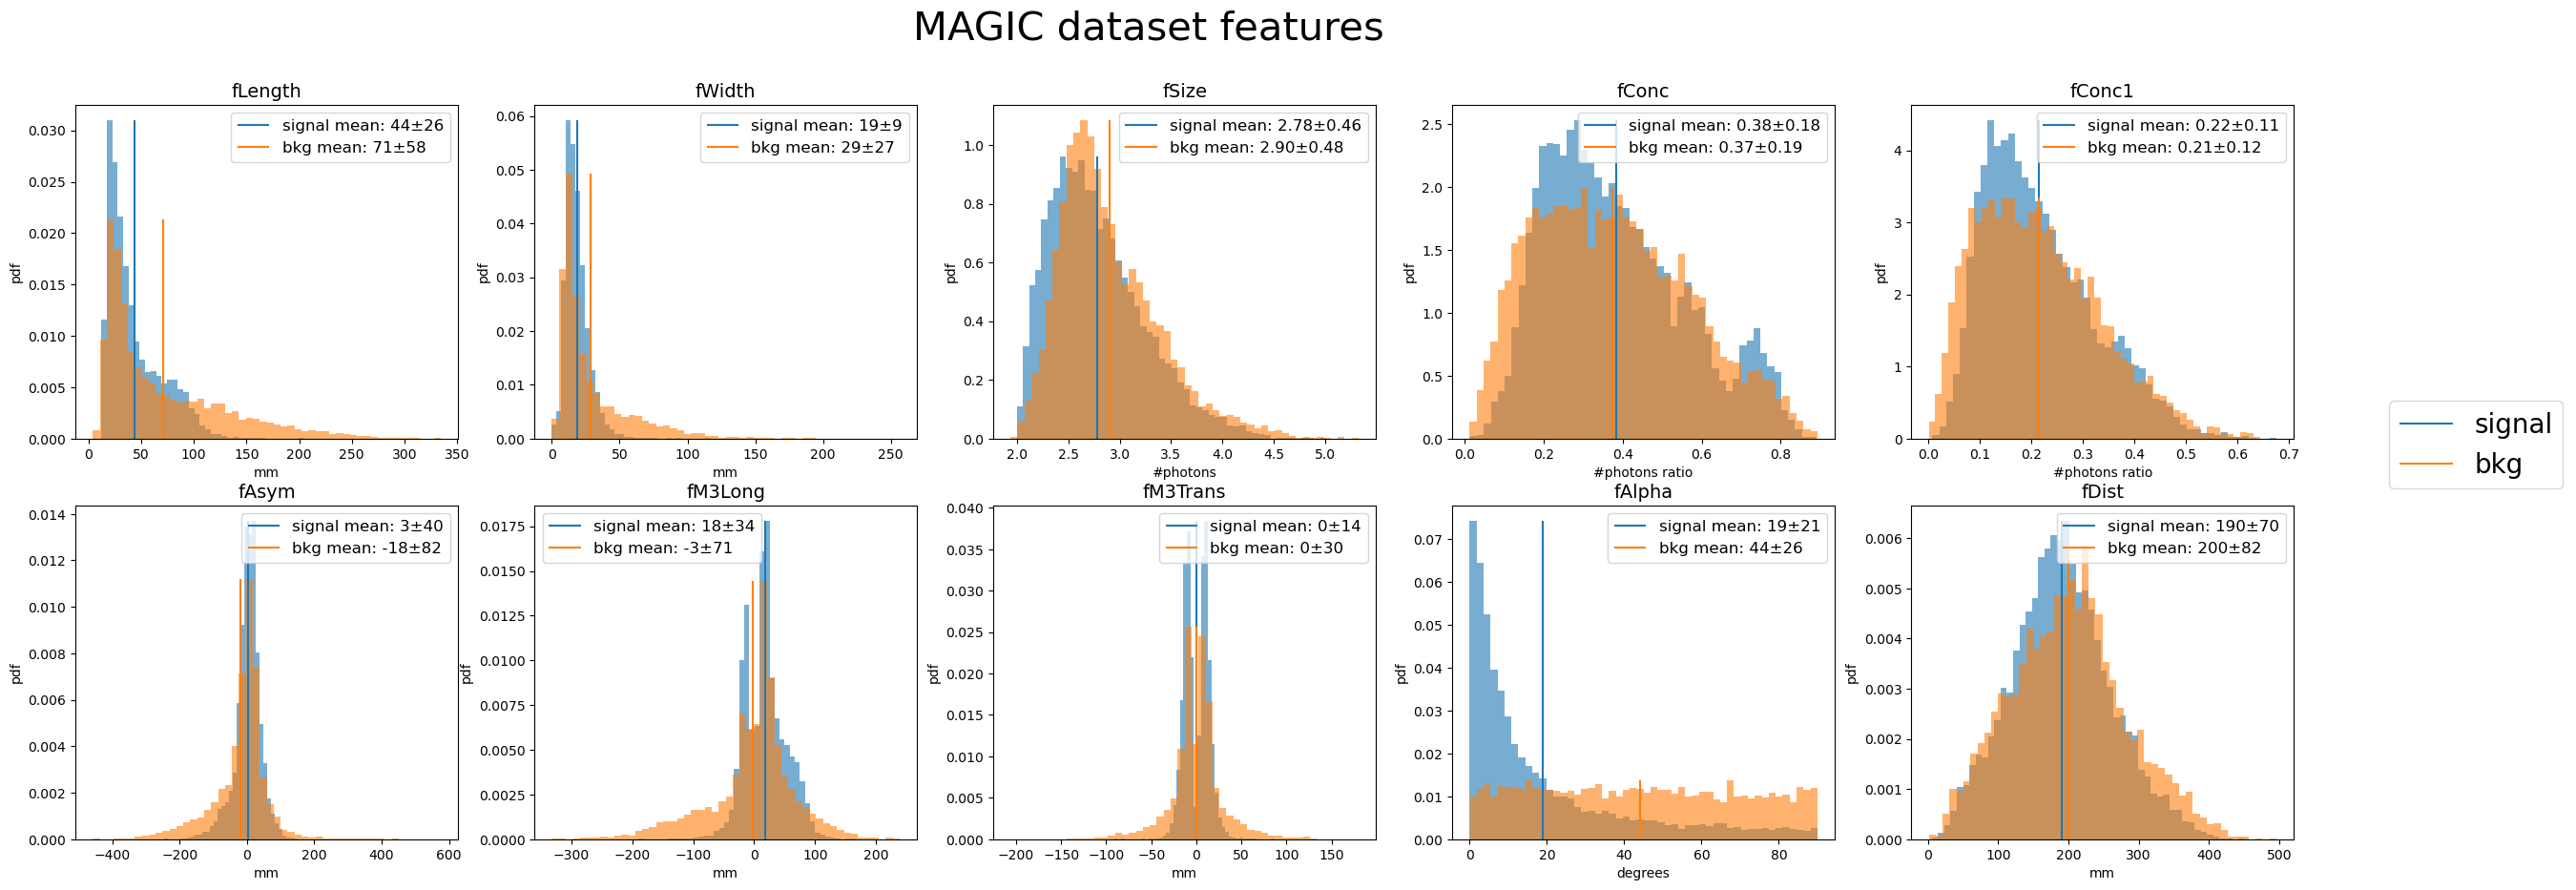

In [6]:
# plots

features_plot(datasig, databkg, features, 'MAGIC dataset features')

### 2. Study the correlations

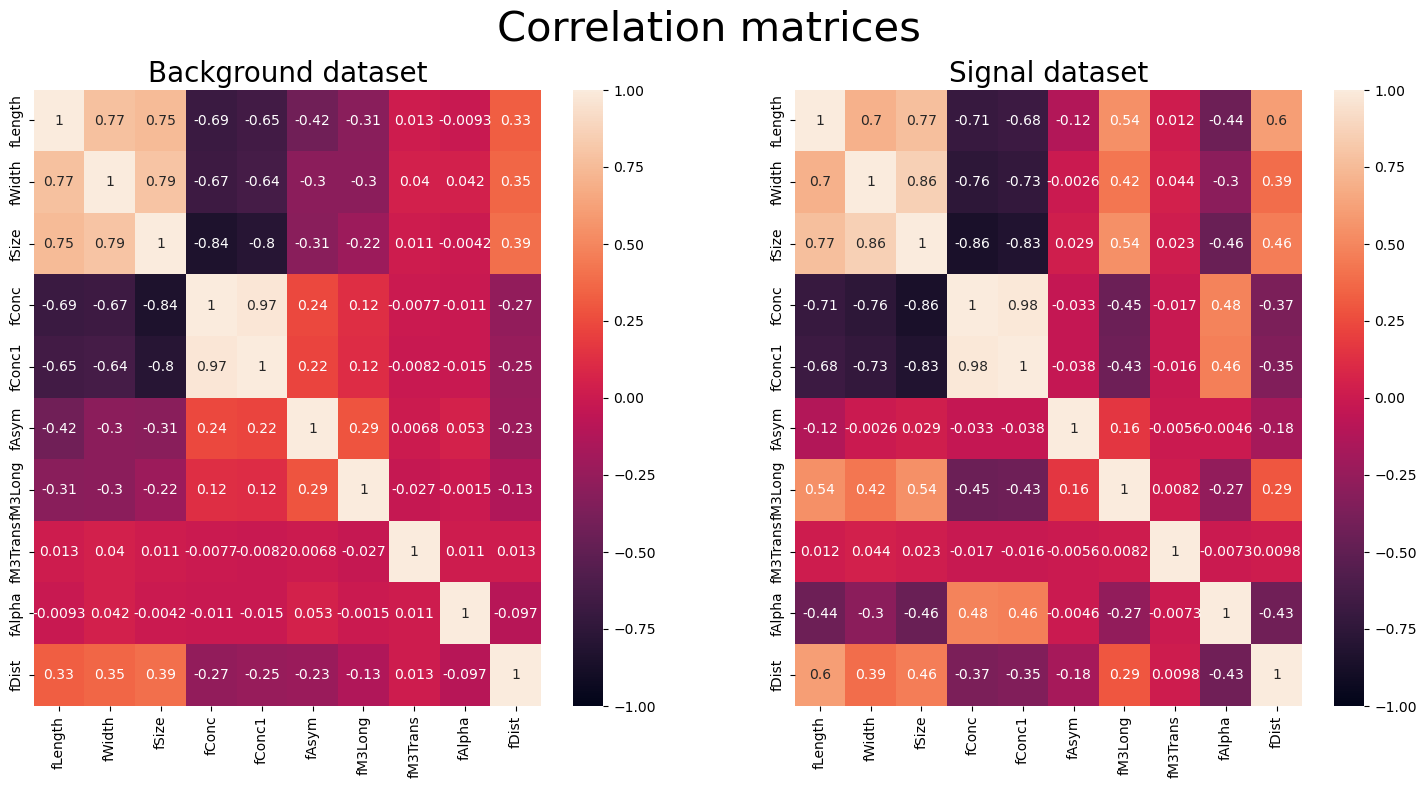

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

fig.suptitle('Correlation matrices', fontsize=30)

sns.heatmap(databkg.corr(), annot=True, vmin=-1, vmax=1, ax=ax[0])
sns.heatmap(datasig.corr(), annot=True, vmin=-1, vmax=1, ax=ax[1])

ax[0].set_title('Background dataset', fontsize=20)
ax[1].set_title('Signal dataset', fontsize=20)

plt.show()

### 3. Rescaled variables

In [6]:
# computing features means and std
means_all = data_c.mean(axis=0)
std_all = data_c.std(axis=0)

# rescaling
data_rescaled = (data_c-means_all)/std_all
data_rescaled = data_rescaled.drop(columns='class')
data_rescaled['class'] = Y

### Pairplot

/Users/giuliadoda/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

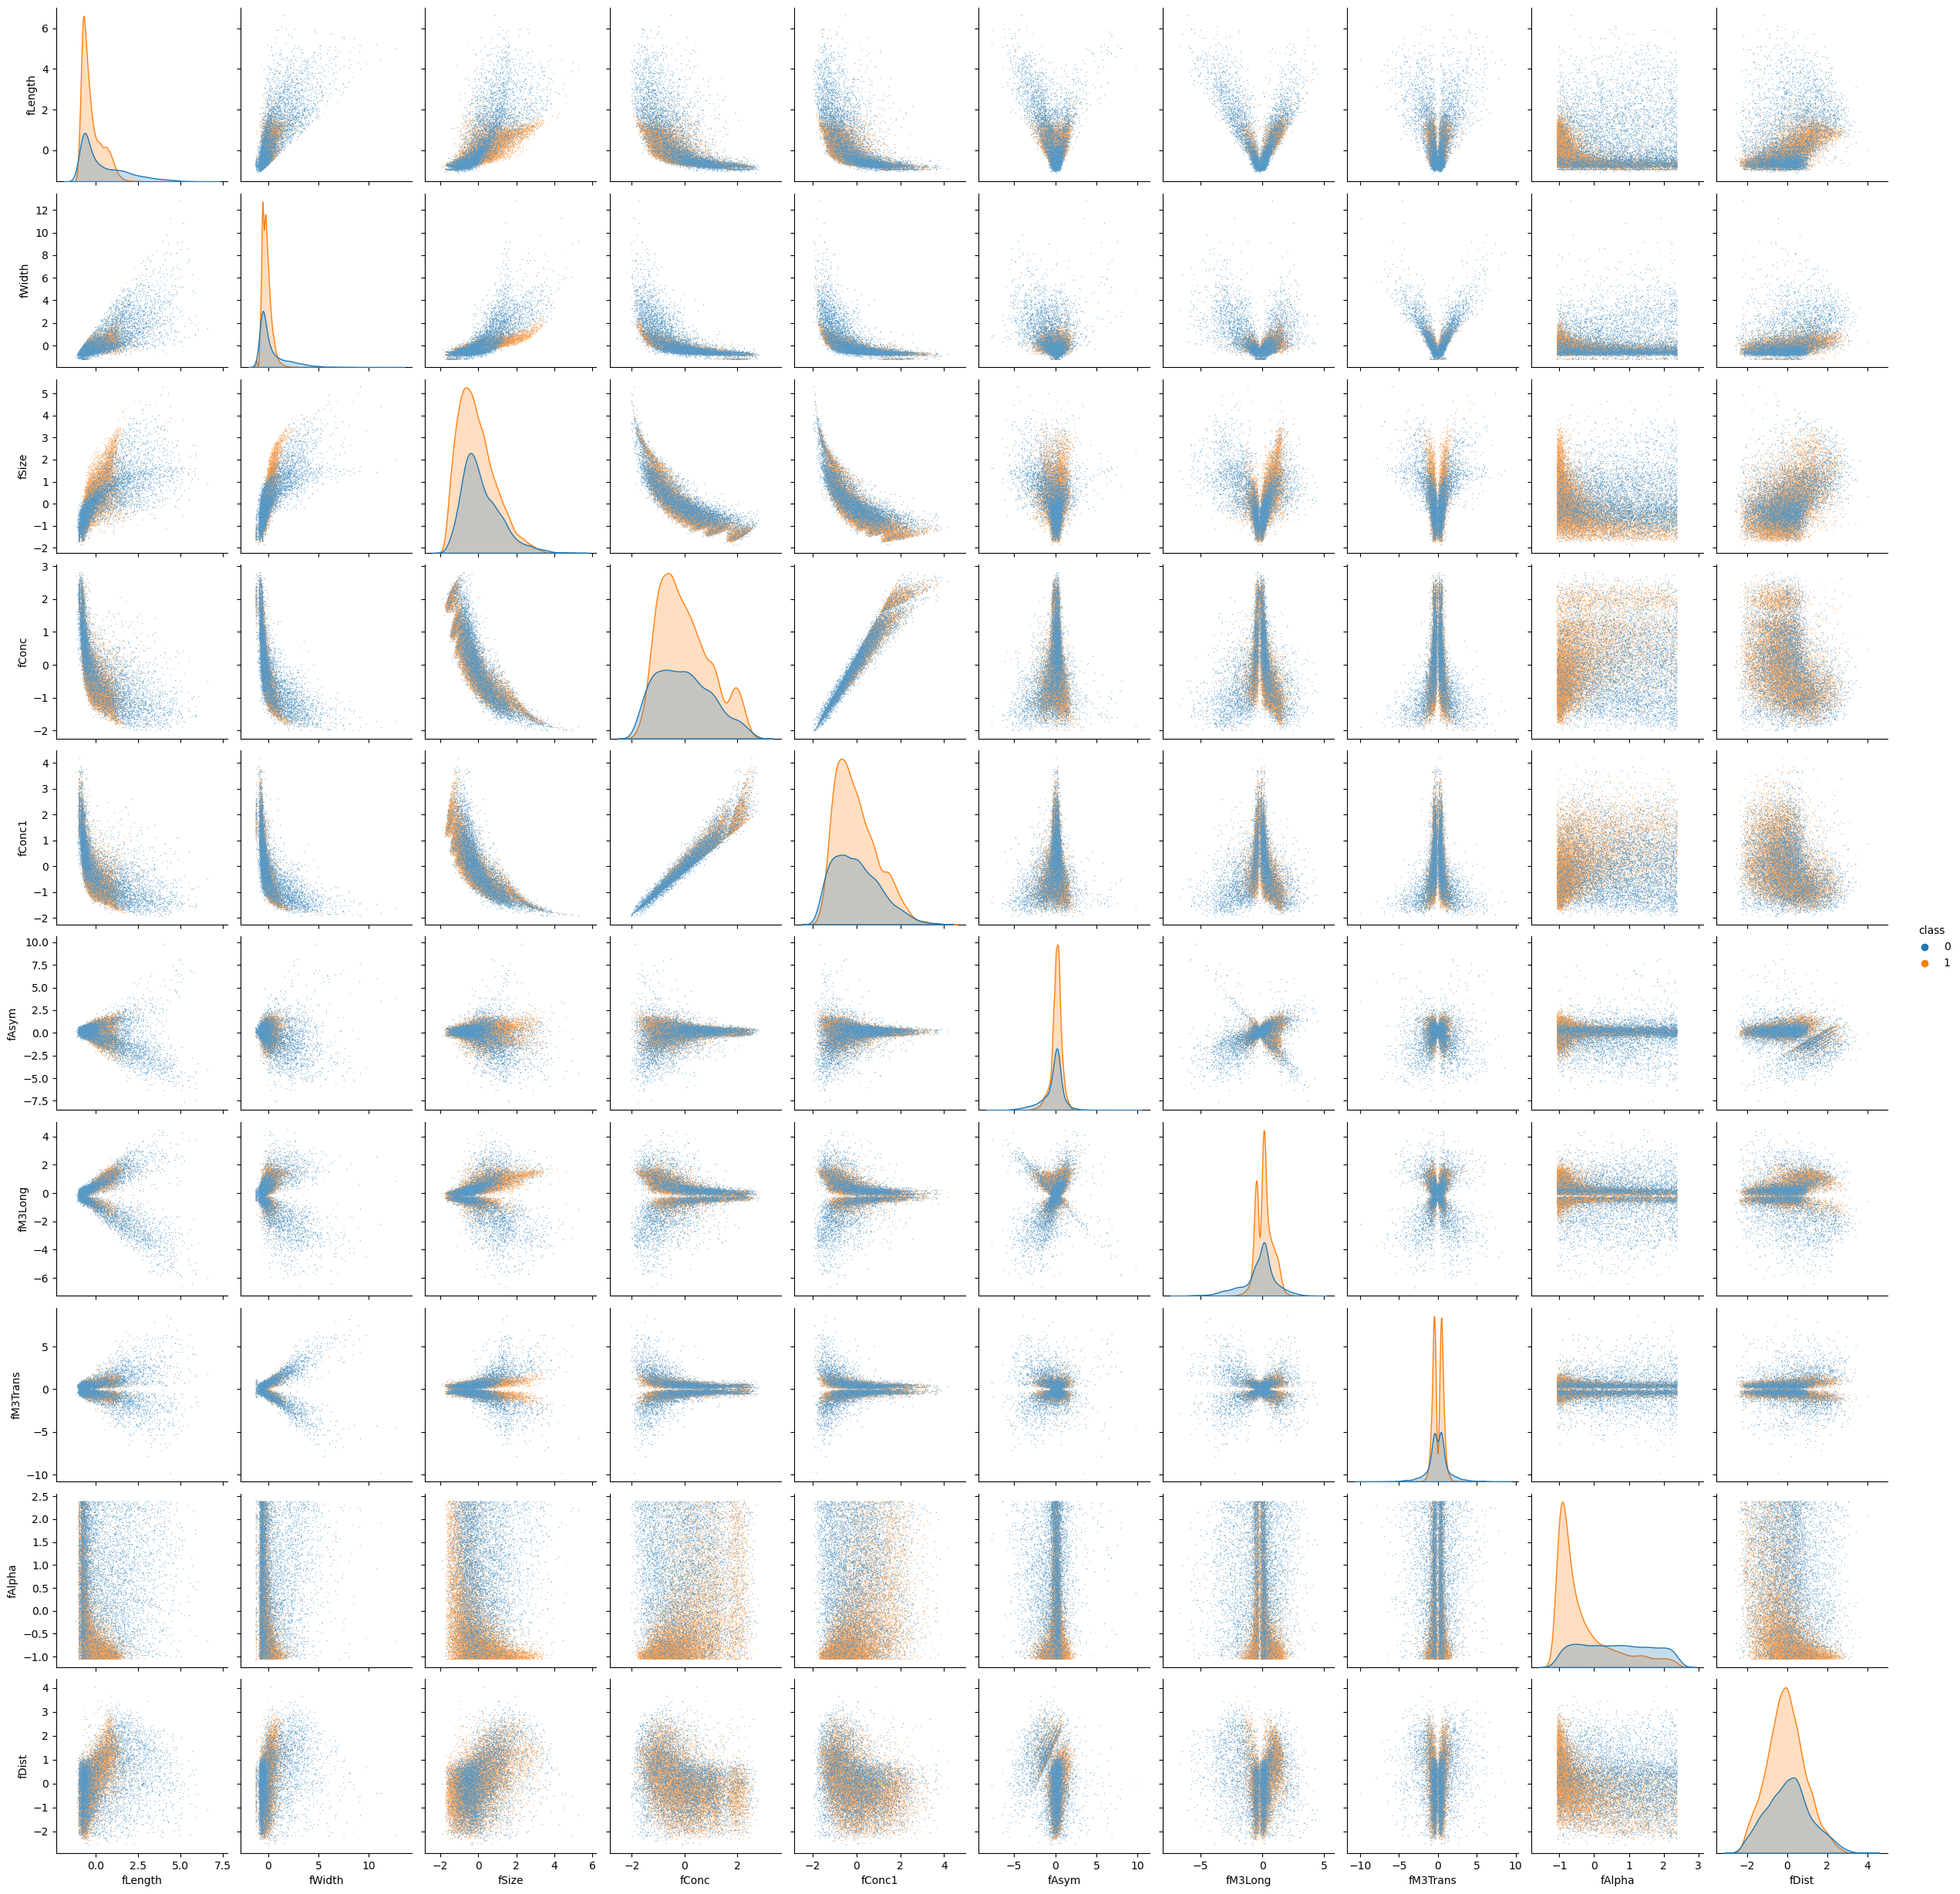

In [74]:
sns.pairplot(data_rescaled, hue='class', plot_kws={'s':0.5})

### 4. PCA

In [ ]:
# to do

### 5. Classification

In [7]:
# remove fAlpha feature from rescaled data
data_noalpha = data_rescaled.drop(columns='fAlpha')

### SVM

In [8]:
# define training and test set
X = data_noalpha.copy(deep=True)
X = data_noalpha.drop(columns='class')

m_training = 12000
m_test = 7000

# splitting and shuffling data
X_train, X_test, y_train, y_test = train_test_split(X, Y)

print("X_train shape:", X_train.shape,"\tX_test shape:", X_test.shape, "\ny_train shape:",  y_train.shape,"\ty_test shape:", y_test.shape)

labels, freqs = np.unique(y_train, return_counts=True) 
print("Labels in training dataset:\t", labels)
print("Frequencies in training dataset:", freqs)

# define SVM model, then train and test
# polynomial kernel
C_par_poly = 15
gamma_par_poly = 0.1
print('\nC parameter for polynomial kernels:', C_par_poly)
print('gamma parameter for polynomial kernels:', gamma_par_poly)
# degree 2
poly2_svm = SVC(kernel='poly', degree=2, C=C_par_poly, gamma=gamma_par_poly)
poly2_svm.fit(X_train, y_train)
poly2_svm_predict = poly2_svm.predict(X_test)
poly2_svm_accuracy = skm.accuracy_score(y_test, poly2_svm_predict)
print(f'\nPolynomial kernel with degree=2 accuracy: {poly2_svm_accuracy:.3f}')

# degree 3
poly3_svm = SVC(kernel='poly', degree=3, C=C_par_poly, gamma=gamma_par_poly)
poly3_svm.fit(X_train, y_train)
poly3_svm_predict = poly3_svm.predict(X_test)
poly3_svm_accuracy = skm.accuracy_score(y_test, poly3_svm_predict)
print(f'\nPolynomial kernel with degree=3 accuracy: {poly3_svm_accuracy:.3f}')

# degree 4
poly4_svm = SVC(kernel='poly', degree=4, C=C_par_poly, gamma=gamma_par_poly)
poly4_svm.fit(X_train, y_train)
poly4_svm_predict = poly4_svm.predict(X_test)
poly4_svm_accuracy = skm.accuracy_score(y_test, poly4_svm_predict)
print(f'\nPolynomial kernel with degree=4 accuracy: {poly4_svm_accuracy:.3f}')

# RBF kernel
rbf_svm = SVC(kernel='rbf', C=10, gamma=1)
rbf_svm.fit(X_train, y_train)
rbf_svm_predict = rbf_svm.predict(X_test)
rbf_svm_accuracy = skm.accuracy_score(y_test, rbf_svm_predict)
print(f'\nRBF kernel accuracy: {rbf_svm_accuracy:.3f}')

X_train shape: (14264, 9) 	X_test shape: (4755, 9) 
y_train shape: (14264,) 	y_test shape: (4755,)
Labels in training dataset:	 [0 1]
Frequencies in training dataset: [5019 9245]

C parameter for polynomial kernels: 15
gamma parameter for polynomial kernels: 0.1

Polynomial kernel with degree=2 accuracy: 0.788

Polynomial kernel with degree=3 accuracy: 0.770

Polynomial kernel with degree=4 accuracy: 0.774

RBF kernel accuracy: 0.823


Highest accuracy: 0.828 	 Corresponding gamma parameter: 0.5


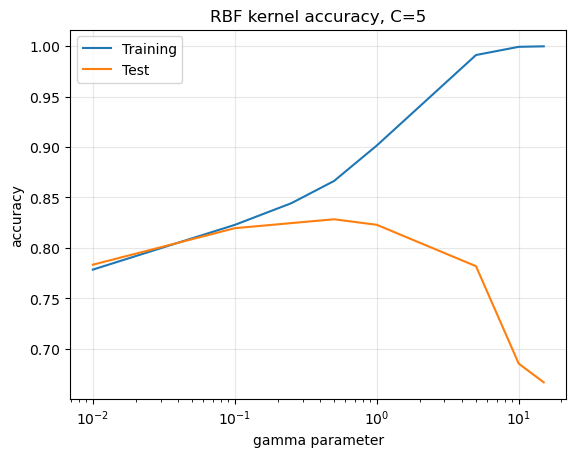

In [20]:
# try different parameters and see the trend for RBF
gamma_values = [0.01, 0.1, 0.25, 0.5, 1, 5, 10, 15]
RBFmodels = [SVC(kernel='rbf', C=5, gamma=i) for i in gamma_values]

# train every model
for mod in RBFmodels:
    mod.fit(X_train, y_train)

# make predictions on test set with every model
RBFtrain_predictions = [mod.predict(X_train) for mod in RBFmodels]
RBFtest_predictions = [mod.predict(X_test) for mod in RBFmodels]

# calculate train and test accuracy
RBFtrain_acc_list = [ skm.accuracy_score(y_train, pred) for pred in RBFtrain_predictions ]
RBFtest_acc_list = [ skm.accuracy_score(y_test, pred) for pred in RBFtest_predictions ]

best_idx = np.argmax(RBFtest_acc_list)
print(f'Highest accuracy: {np.max(RBFtest_acc_list):.3f} \t Corresponding gamma parameter: {gamma_values[best_idx]}')

# plot
fig, ax = plt.subplots()
ax.grid(alpha=0.3)
ax.plot(gamma_values, RBFtrain_acc_list, label='Training')
ax.plot(gamma_values, RBFtest_acc_list, label='Test')
ax.set_title('RBF kernel accuracy, C=5')
ax.set_xlabel('gamma parameter')
ax.set_ylabel('accuracy')
ax.set_xscale('log')
ax.legend()

plt.show()

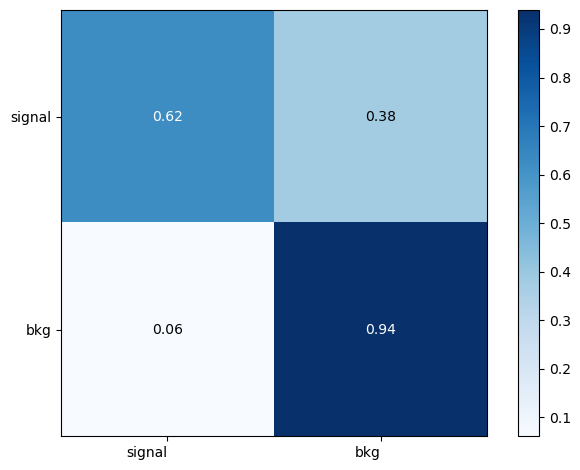

In [38]:
# confusion matrices for best RBF classifier
bestRBF = SVC(kernel='rbf', C=5, gamma=0.5)
bestRBF.fit(X_train, y_train)
bestRBF_pred = bestRBF.predict(X_test)

labels, freqs = np.unique(y_test, return_counts=True) 
cm_RBF = skm.confusion_matrix(y_test, bestRBF_pred)

fig = plt.figure()

imRBF = plt.imshow(cm_RBF/freqs[:,None], cmap='Blues', interpolation='nearest')
plt.xticks([0,1], ['signal', 'bkg'],ha="right",rotation=0)
plt.yticks([0,1], ['signal', 'bkg'],ha="right",rotation=0)
cm_RBF = cm_RBF/freqs[:,None]

fmt = '.2f'

thresh = cm_RBF.max() / 2.
for i in range(cm_RBF.shape[0]):
    for j in range(cm_RBF.shape[1]):
        plt.text(j, i, format(cm_RBF[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_RBF[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(imRBF, location = 'right') 
plt.show()

### BOOSTED TREES

In [ ]:
# to do